## YouTube Trending Video Analysis & Prediction

### Joel Day, Caleb McCurdy, & Lane Whitmore

### The University of San Diego

#### ADS 508 - Data Science Cloud Computing

In [2]:
# General imports
import pandas as pd
import numpy as np

# nlp processing imports
import string
import re
import nltk

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sagemaker imports
import sagemaker
# from sagemaker.sklearn.processing import 
from sagemaker import get_execution_role
from sklearn.feature_extraction.text import CountVectorizer

# athena connection imports
!pip install pyathena
from pyathena import connect
import boto3

  Using cached pyathena-2.23.0-py3-none-any.whl (67 kB)


## Establishing Athena for SQL Queries

In [3]:
region = boto3.Session().region_name
role = get_execution_role()

In [4]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

bucket = "ads508youtubebucket"

In [5]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [6]:
# temp query storage
s3_athena = "s3://ads508youtubebucket/athena/tmp/"

# file storage
youtube_dir = "s3://ads508youtubebucket/athena/files/"

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

### Creating Database

In [7]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

""


### Creating Tables

#### CSV Tables

Currently, the tables below are still struggling to appropriately populate the tables. If the data type is anything but strings, the column becomes null for all values and the comma seperation is not consistent.

In [82]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [83]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,6bFc8z35sk0,I Had A Mental Breakdown And Cut Awful Bangs,2021-03-16T18:31:39Z,UCR-QYzXrZF8yFarK8wZbHog,Colleen Ballinger,23,2021-03-20T00:00:00Z,colleen ballinger|colleen|ballinger|psychosopr...,615446,33500,1155,13367,https://i.ytimg.com/vi/6bFc8z35sk0/default.jpg,False,False,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,RoOZTKz0TsQ,The SEASON 6 BATTLEPASS is INSANE!! (100% UNLO...,2021-03-16T09:10:00Z,UCJAPcllL_VRxUiNKtaLOpzw,More SypherPK,20,2021-03-20T00:00:00Z,fortnite|fortnite battle royale|ninja|competit...,1056369,27700,1227,1854,https://i.ytimg.com/vi/RoOZTKz0TsQ/default.jpg,False,False,Today I react to the new Season 6 Battle Pass!...
4,bVnHisJl7Uc,Honest Trailers | WandaVision,2021-03-16T17:00:28Z,UCOpcACMWblDls9Z6GERVi1A,Screen Junkies,1,2021-03-20T00:00:00Z,screen junkies|fandom|honest trailers|screenju...,1012785,47974,813,3149,https://i.ytimg.com/vi/bVnHisJl7Uc/default.jpg,False,False,►►Subscribe to ScreenJunkies!► https://fandom....
5,AVIaZbvYAng,Ranboo bakes a cake [ANIMATION],2021-03-16T21:00:05Z,UCfUFXTeJlQsJUQHMR90nLHA,Kazoo Does Art,1,2021-03-20T00:00:00Z,kazoo|doesart|kazoodoesart|kazoo's art channel...,213984,36288,50,919,https://i.ytimg.com/vi/AVIaZbvYAng/default.jpg,False,False,Thank you all so much for watching!! This anim...
6,dsCjRjA4O7Y,The NEW Crisis in Cosmology,2021-03-16T20:15:01Z,UC7_gcs09iThXybpVgjHZ_7g,PBS Space Time,27,2021-03-20T00:00:00Z,Space|Outer Space|Physics|Astrophysics|Quantum...,545889,25332,484,2686,https://i.ytimg.com/vi/dsCjRjA4O7Y/default.jpg,False,False,https://www.patreon.com/pbsspacetimeI have goo...
7,RUJUAHYkBXM,DIY Upcycled Home Decor EXTREME CHALLENGE ft. ...,2021-03-16T18:00:25Z,UCtwzsvzRCfPddq2gPlgKW1w,Lone Fox,22,2021-03-20T00:00:00Z,Lone Fox Home|Drew Scott DIY|Imdrewscott DIY|D...,215781,15037,196,687,https://i.ytimg.com/vi/RUJUAHYkBXM/default.jpg,False,False,☆ Watch The Sorry Girls Video: https://www.you...
8,nNBDjJosK74,Post Malone - Hollywood's Bleeding (Live From ...,2021-03-15T17:41:25Z,UCOhtMAg7xh8wv_wUHMgFc-Q,PostMaloneVEVO,10,2021-03-20T00:00:00Z,Post Malone|post Malone grammys|post grammys|p...,2904235,157669,2196,8251,https://i.ytimg.com/vi/nNBDjJosK74/default.jpg,False,False,“Hollywood’s Bleeding” (Live From The 63rd GRA...
9,LALR0ovhVks,At Home With Kim Kardashian - The End of An Er...,2021-03-15T16:00:05Z,UCRXiA3h1no_PFkb1JCP0yMA,Vogue,24,2021-03-20T00:00:00Z,keeping up with the kardashians|kim kardashian...,2769262,87874,3163,5101,https://i.ytimg.com/vi/LALR0ovhVks/default.jpg,False,False,None


In [62]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [63]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Y4wWqz3ng_U,This Kinda SUCKS! - Cyberpunk 2077 Next Gen Up...,2022-02-15T18:03:04Z,UCiHFS5txB0O7jckRk-oK8XQ,DreamcastGuy,20,2022-02-19T00:00:00Z,xbox|pc|one|sony|playstation|dreamcast|gaming|...,227405,4959,0,2621,https://i.ytimg.com/vi/Y4wWqz3ng_U/default.jpg,False,False,Like and subscribe if you enjoyed it!Follow me...
1,zk2rxLH80XA,The SHOCKING Truth about Yae Miko! 4★ Weapon C...,2022-02-16T02:52:38Z,UC8BTtymnCZ7jTvt09cjPMwQ,Gacha Gamer,20,2022-02-19T00:00:00Z,genshin impact|genshin impact mobile|genshin i...,382598,13241,0,1025,https://i.ytimg.com/vi/zk2rxLH80XA/default.jpg,False,False,Yae Miko surprised me in several ways and with...
2,yPYW5z7O1rw,Mo3 - For The Love (Official Visualizer),2022-02-14T20:00:29Z,UC_PQ7gGEKIwJv0YsnxH3dUw,HSM,10,2022-02-19T00:00:00Z,Mo3|Dallas|Texas|Rap Music|Badazz,373768,25484,0,1356,https://i.ytimg.com/vi/yPYW5z7O1rw/default.jpg,False,False,#Mo3 #ForTheLove #HSMOfficial Visualizer for ...
3,eEQMtIX61LA,"Bruno Mars, Anderson .Paak, Silk Sonic - Love'...",2022-02-14T20:00:09Z,UCoUM-UJ7rirJYP8CQ0EIaHA,Bruno Mars,10,2022-02-19T00:00:00Z,bruno mars|silk sonic|anderson .paak|anderson ...,1541464,85978,0,4419,https://i.ytimg.com/vi/eEQMtIX61LA/default.jpg,False,False,"Bruno Mars, Anderson .Paak, Silk Sonic - Love'..."
4,J6CbElkmmMA,GIANT ALEX Mod in Among Us...,2022-02-16T23:45:01Z,UCXHGoWpySS0smjanTUDa6Gw,GameToons Gaming,20,2022-02-19T00:00:00Z,among us|among us logic|among us adventures|ga...,989968,16910,0,516,https://i.ytimg.com/vi/J6CbElkmmMA/default.jpg,False,False,► SUBSCRIBE to GameToons Gaming! -https://www....
5,2bZYqFsU72Y,The First-Ever All-Electric Chevy Silverado – ...,2022-02-14T00:16:41Z,UCSVpCNZzOeMekuMiFze3fnQ,Chevrolet,2,2022-02-19T00:00:00Z,Chevrolet|Chevy|Silverado EV|Electric Silverad...,11553038,20700,0,3803,https://i.ytimg.com/vi/2bZYqFsU72Y/default.jpg,False,False,"With available Four-Wheel Steer, an available ..."
6,0z1dsxJcAPg,SURPRISING MY BOYFRIEND WITH HIS DREAM CAR !,2022-02-15T04:12:12Z,UCABbEMDC2EdsLuF0pkoV_cg,Jathaly,22,2022-02-19T00:00:00Z,new car|surprise|surprising my boyfriend|car g...,294989,17246,0,975,https://i.ytimg.com/vi/0z1dsxJcAPg/default.jpg,False,False,!!!!!! WELCOME TO JATHALY !!!!!Our solo channe...
7,wyWo_qkjlLk,How rich people vs really rich people act at t...,2022-02-16T16:31:41Z,UCJSICzUeXSxBvc0UAf2Up8g,Nicholas Crown,22,2022-02-19T00:00:00Z,[None],424249,50917,0,109,https://i.ytimg.com/vi/wyWo_qkjlLk/default.jpg,False,False,
8,xK5qVtczVmk,Toosii - Love Me Easy (Official Audio),2022-02-14T17:50:13Z,UCUtmzHuW43bFbUP-Xl0TTKA,Toosii 2x,10,2022-02-19T00:00:00Z,[None],458758,29118,0,1201,https://i.ytimg.com/vi/xK5qVtczVmk/default.jpg,False,False,Stream // Download Toosii’s “Pretty Girls Love...
9,VmI0YIqdjv8,I'M PREGNANT!,2022-02-14T14:56:53Z,UCF2oW5-MO8dB6ul9WH9xi0A,blndsundoll4mj,22,2022-02-19T00:00:00Z,[None],784231,39162,0,10912,https://i.ytimg.com/vi/VmI0YIqdjv8/default.jpg,False,False,


In [60]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId int,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [ ]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 10", conn)

#### JSON Tables

In [ ]:

pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_json", conn)

ca_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_json (
                        kind: string, 
                        etag: string, 
                        items: array<struct<kind: string, 
                                            etag: string,
                                            id: int,
                                            snippet:struct<title: string,
                                                           assignable: boolean,
                                                           channelId: string>>>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 'ignore.malformed.json' = 'true')
                        LOCATION 's3://ads508youtubebucket/youtubeStatistics/json/can/';
"""

pd.read_sql(ca_json_create, conn)

In [ ]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_json;", conn)

## Data Exploration

#### US Gaming Exploration

In [100]:
# 20 is the category id for gaming in each country
us_gamingvlog = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gamingvlog.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,qcY9qy1SaL8,"I Survived 2,000 Days in HARDCORE Minecraft...",2021-10-23T12:15:11Z,UCFrVj6wBM42y3XuKCAj8n5A,SB737,20,2021-10-27T00:00:00Z,minecraft|gaming|sb737|sb minecraft|sb|let's p...,2163189,123429,1683,8435,https://i.ytimg.com/vi/qcY9qy1SaL8/default.jpg,False,False,"BUY 2,000 DAYS POSTER HERE: https://sb737.stor..."
1,8kVXGfKIk9I,I made a minecraft mod EVERY DAY for 100 DAYS,2021-10-23T19:00:13Z,UCfGkyZGTurOs8Xrylyu4G2Q,Its Jim,20,2021-10-27T00:00:00Z,techonoblade|minecraft|fundy|wilbur soot|tommy...,773055,16321,436,859,https://i.ytimg.com/vi/8kVXGfKIk9I/default.jpg,False,False,I added a mod every day to my Minecraft hardco...
2,1ruCFtzohh8,Chapter 1 Fortnite is Back!,2021-10-24T13:35:47Z,UCh7EqOZt7EvO2osuKbIlpGg,Lachlan,20,2021-10-27T00:00:00Z,lachlan lachy fortnite battle royale pubg batt...,864778,50238,532,1588,https://i.ytimg.com/vi/1ruCFtzohh8/default.jpg,False,False,Today we go back to OG Fortnite with a fun tou...
3,uWSUnZ_exoM,I Stole my Friends Among Us Statue,2021-10-23T14:00:32Z,UCvt0HYxX34vUvqu66HLXeUw,rekrap2,20,2021-10-27T00:00:00Z,rekrap2|rekrap|rek|Echocraft|Boatclutch,659838,20315,358,1242,https://i.ytimg.com/vi/uWSUnZ_exoM/default.jpg,False,False,"I stole my Friends Among Us statue, and it sta..."
4,3437syY-2P0,"Minecraft Manhunt, But Clutching Gives OP Item...",2021-10-24T00:01:02Z,UCWWcJg7XWc5erpRJJtO1mgw,P0LAND,20,2021-10-27T00:00:00Z,Minecraft|Challenge|Minecraft Challenge|Minecr...,445194,16732,310,856,https://i.ytimg.com/vi/3437syY-2P0/default.jpg,False,False,"Minecraft Manhunt, But Clutching Gives OP Item..."


Preparing the data for exploration by adjusting the necessary column types.

In [101]:
print("Length of data frame:", us_gamingvlog.shape[0])
print("Width of data frame:", us_gamingvlog.shape[1])
print(us_gaming.dtypes)


# Change to integer
us_gamingvlog['categoryid'] = us_gamingvlog['categoryid'].astype(int) 
us_gamingvlog['view_count'] = us_gamingvlog['view_count'].astype(int)
us_gamingvlog['likes'] = us_gamingvlog['likes'].astype(int)
us_gamingvlog['dislikes'] = us_gamingvlog['dislikes'].astype(int)
us_gamingvlog['comment_count'] = us_gamingvlog['comment_count'].astype(int)

# Change to datetime
us_gamingvlog['publishedat'] = pd.to_datetime(us_gamingvlog['publishedat'], infer_datetime_format=True)
us_gamingvlog['trending'] = pd.to_datetime(us_gamingvlog['trending'], infer_datetime_format=True)
us_gamingvlog.dtypes

Length of data frame: 37071
Width of data frame: 16
video_id                     object
title                        object
publishedat          datetime64[ns]
channelid                    object
channeltitle                 object
categoryid                    int64
trending             datetime64[ns]
tags                         object
view_count                    int64
likes                         int64
dislikes                      int64
comment_count                 int64
thumbnail_link               object
comments_disabled            object
ratings_disabled             object
description                  object
dtype: object


video_id                     object
title                        object
publishedat          datetime64[ns]
channelid                    object
channeltitle                 object
categoryid                    int64
trending             datetime64[ns]
tags                         object
view_count                    int64
likes                         int64
dislikes                      int64
comment_count                 int64
thumbnail_link               object
comments_disabled            object
ratings_disabled             object
description                  object
dtype: object

#### Creating Visualizations

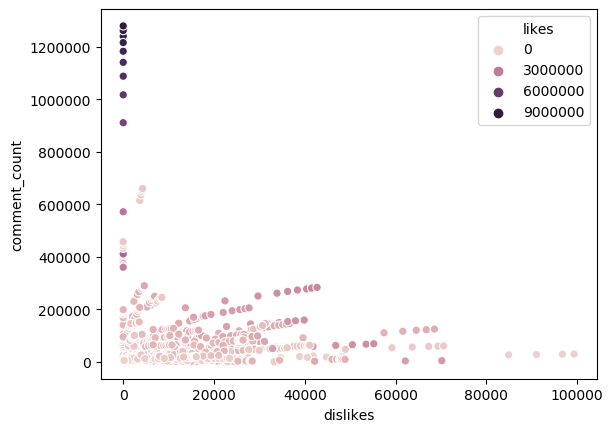

In [102]:
sns.scatterplot(data = us_gamingvlog, x = us_gamingvlog.dislikes, y = us_gamingvlog.comment_count, hue = us_gamingvlog.likes)
plt.show()

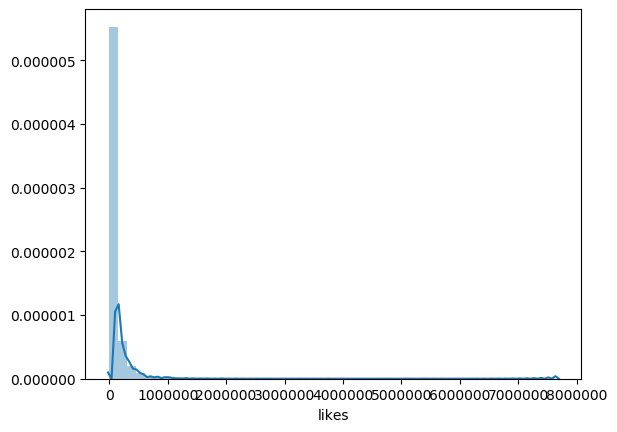

In [103]:
sns.distplot(us_gamingvlog.likes)
plt.show()

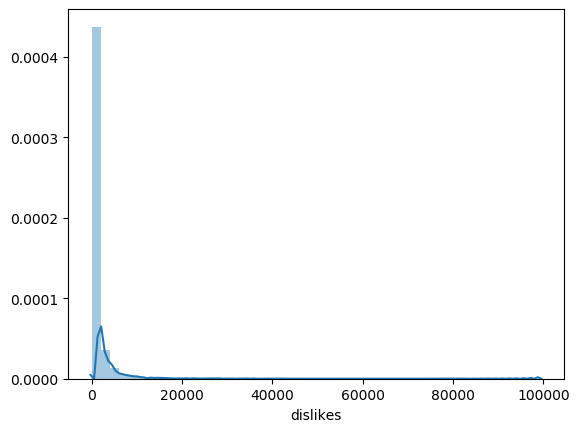

In [104]:
sns.distplot(us_gamingvlog.dislikes)
plt.show()

### Data could also be accessed like this

In [73]:
bucket = "ads508youtubebucket"
data_key = "US_youtube_trending_data.csv"
data_location_us = "s3://{}/youtubeStatistics/csv/usa/{}".format(bucket, data_key)

In [74]:
us_df = pd.read_csv(data_location_us)

As shown below, ingesting the data by directly accessing the bucket through Pandas creates a very clean dataset to work with.

In [81]:
us_df['categoryId'].shape

(189190,)

### NLP

The current dataframe is too large to implement NLP using Sklearn. The dataframes could be made smaller during ingestion phase by only using certain categories that our 'creators' exist in. 

In [ ]:
# stopwords from nltk

nltk.download()

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

# 3 words to have more context
vec = CountVectorizer(min_df=1, analyzer='word', ngram_range=(3, 3))

We could then clean the text here and use Count Vectorizer from SkLearn to transform the long form text within the csvs to more manageable counts. This will make our data wide. Doing so will allow for transformation to Athena easier than transforming with strings. 

In [ ]:
# Clean words from punctuation
def cleaning_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [ ]:
tag = ca_df['tags']

cleaning_text(tag)


In [ ]:
tags = vec.fit_transform(tag)

In [ ]:
print(tags.shape)

In [ ]:
vec.get_feature_names()